In [254]:
import pandas as pd
import os
import geopandas as gpd
import geoplot as gplt
import scipy as sp
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import sys

In [255]:
wd = '/home/beeb/Insync/sei2112@columbia.edu/Google Drive/Columbia SusDev PhD/Research/My work/predictArsenic/'
placesPath = 'data/intermediate/googlePlaces/results.txt'
shapePath = 'data/raw/shapefiles/bgd_adm_bbs_{date}_SHP/bgd_admbnda_adm{level}_bbs_{date}.shp'.format(date = '20201113', level = '{}')
outPath = 'data/intermediate/placesToShapes/results.shp'
figPath = 'output/intermediate/placesToShapes/plot.png'
os.chdir(wd)

In [256]:
# read in data, re-format
datBad = pd.read_json(placesPath)
dat = pd.DataFrame(data = {'results' : datBad.loc['results',:],
                          'query' : datBad.loc['query',:],
                          'status' : datBad.loc['status',:]})

In [257]:
# extract latitudes, longitudes and names
dat['latitude'] = [result[0]['geometry']['location']['lat'] 
                   for result in dat['results']]
dat['longitude'] = [result[0]['geometry']['location']['lng'] 
                    for result in dat['results']]
#names = [result[0]['name'] for result in dat['results']]
address_components = [result[0]['address_components'] 
                      for result in dat['results']]
countries = [
    [x['long_name'] for x in address_component if x['types'][0] == 'country'] 
    for address_component in address_components
]
dat['country'] = np.array(countries).flatten()
dat['formatted_address'] = [result[0]['formatted_address'] 
                            for result in dat['results']]

In [258]:
# get rid of any observations outside of Bangladesh, drop results column and duplicates
dat = dat[dat.country == 'Bangladesh']\
    .drop('results', axis = 1)

In [259]:
# there are some entries where multiple places have been coded to the same address, get rid of these
nAddress = dat.formatted_address.value_counts()
dat = dat.merge(pd.DataFrame(nAddress).rename(columns = {'formatted_address': 'nobs'}), 
                left_on = 'formatted_address', right_index = True)
df = dat[['latitude', 'longitude']].drop_duplicates()


In [260]:
# put these into a geodataframe
#df = pd.DataFrame(data = {'longitude': lons, 'latitude': lats},#, 'formatted_address': formatted_address}, 
#                  index = names).drop_duplicates()
#gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude))
#gdf.head()

In [261]:
# read in the Bangladesh shapefile

In [262]:
shp = gpd.read_file(shapePath.format(0))

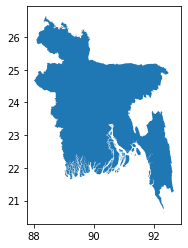

In [263]:
shp.plot()

In [264]:
# filter out any entries in our gdf which are outside Bangladesh, check 
# this doesn't involve dropping > 10% of obs
beginPointsN = df.shape[0]
df = df[df.latitude <= shp.bounds.loc[0, 'maxy']]
df = df[df.latitude >= shp.bounds.loc[0, 'miny']]
df = df[df.longitude < shp.bounds.loc[0, 'maxx']]
df = df[df.longitude >= shp.bounds.loc[0, 'minx']]
endPointsN = df.shape[0]
assert endPointsN > 0.9 * beginPointsN

In [265]:
df.head()

,latitude,longitude
"SASIRKANDI,+Ragdi,+Bangladesh",23.273686,90.008161
"Maliartek,+Ashwadia,+Bangladesh",22.824438,91.130505
"Shyllapur,+Goshbag,+Bangladesh",22.823950,91.197716
"Kahalpur,+Atjuri,+Bangladesh",22.899796,89.798977
"Manikchand Para,+Noyabil,+Bangladesh",25.165965,90.198040


In [266]:
#CODE FROM THE INTERWEBS 
# this code creates a voronoi diagram within a bounding box
#https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells

eps = sys.float_info.epsilon

bounding_box = shp.bounds.loc[0, ['minx', 'maxx', 'miny', 'maxy']] # [x_min, x_max, y_min, y_max]

def in_box(towers, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))


def voronoi(towers, bounding_box):
    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)
    print(len(i))
    # Mirror points
    points_center = towers[i, :]
    print(len(points_center))
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)
    # Filter regions
    regions = []
    print(len(vor.regions))
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                       bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor


2044
2044
10221


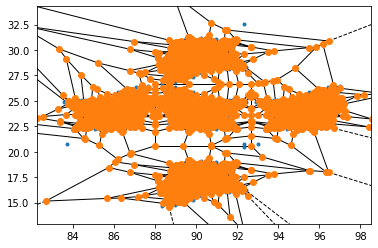

In [267]:
# make a voronoi diagram and plot it
points = np.array([[df.longitude.iloc[i], df.latitude.iloc[i]] for i in range(df.shape[0])])
vor = voronoi(points, bounding_box)
fig = voronoi_plot_2d(vor)
plt.show()

In [268]:
# wild guess at how to do this
regions = [region for region in vor.filtered_regions if len(region) > 0]

# function for turning the voronoi objects into polygons
def getPoly(pointIndices):
    
    # get the vertices for this polygon
    poly = vor.vertices[pointIndices,:]
    
    # turn this into a polygon object
    poly = Polygon(poly)
    
    # check the polygon is valid (i.e. it does not cross itself)
    if not poly.is_valid:
        print('Invalid')
        
    # give it the CRS that Google uses
    poly.crs = 'EPSG:4326'
    return(poly)

polygons = [getPoly(pointIndex) for pointIndex in regions]# if len(pointIndex) > 0]
#dat['vor'] = vor.point_region

In [269]:
# check that all resulting polygons are valid
assert sum([not x.is_valid for x in polygons]) == 0

# turn the polygons into a geoseries and set the CRS
polydf = gpd.GeoSeries(polygons)
polydf.crs = 'EPSG:4326'

# clip to Bangladesh shape
polydf = gpd.clip(polydf, shp)

In [271]:
# add in the area name to each of the polygons
# let's hope that Python doesn't mix all these polygons around so they're all in the same order???
polydf.index = df.index

In [272]:
polydf.to_file(outPath)

In [273]:
polydf.head()

SASIRKANDI,+Ragdi,+Bangladesh           MULTIPOLYGON (((89.25014 22.48758, 89.32177 22...
Maliartek,+Ashwadia,+Bangladesh         POLYGON ((92.45860 22.83538, 91.89263 22.47750...
Shyllapur,+Goshbag,+Bangladesh          POLYGON ((91.74220 22.54127, 91.74566 22.78047...
Kahalpur,+Atjuri,+Bangladesh            POLYGON ((91.74415 22.48748, 91.83589 22.37935...
Manikchand Para,+Noyabil,+Bangladesh    POLYGON ((89.17646 22.56980, 89.17010 22.59658...
Name: geometry, dtype: geometry

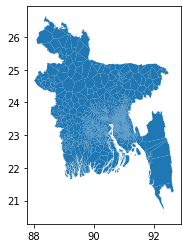

In [274]:
polydf.plot()
plt.savefig(figPath)